<a href="https://colab.research.google.com/github/igvasilev/nlp-cannabis/blob/main/effect_classification_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets sentencepiece --quiet

     |████████████████████████████████| 2.9 MB 2.7 MB/s 
     |████████████████████████████████| 270 kB 54.1 MB/s 
     |████████████████████████████████| 1.2 MB 38.1 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 3.3 MB 14.8 MB/s 
     |████████████████████████████████| 895 kB 37.5 MB/s 
     |████████████████████████████████| 636 kB 49.3 MB/s 
     |████████████████████████████████| 1.3 MB 36.0 MB/s 
     |████████████████████████████████| 243 kB 47.0 MB/s 
     |████████████████████████████████| 125 kB 53.8 MB/s 
     |████████████████████████████████| 160 kB 51.4 MB/s 
     |████████████████████████████████| 271 kB 44.4 MB/s 


In [ ]:
import pandas as pd
import torch
import re
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import datasets

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
from sklearn.model_selection import train_test_split

# The data

In [ ]:
columns = ['PMID', 'Title', 'Abstract', 'Indication', 'Cannabinoid', 'Effect']
data = pd.read_csv('annotated_dataset_05.10.21.csv')
data = data[columns]
data.Abstract = data.Abstract.apply(lambda s: re.sub('[\$#]', '', s))
data.Title = data.Title.apply(lambda s: re.sub('[\$#]', '', s))
data.head()

,PMID,Title,Abstract,Indication,Cannabinoid,Effect
0,10215664,Enhancement mu opioid antinociception by oral ...,The antinociceptive effects of various mu opio...,Pain,THC,positive
1,10353438,Local administration of delta9-tetrahydrocanna...,BACKGROUND. Cannabinoids can reduce nociceptiv...,Pain,THC,positive
2,10357256,Delta9-tetrahydrocannabinol inhibits gastric m...,We investigated involvement of the autonomic n...,Gastrointestinal Diseases,THC,negative
3,10357256,Delta9-tetrahydrocannabinol inhibits gastric m...,We investigated involvement of the autonomic n...,Hypothension,THC,negative
4,10357256,Delta9-tetrahydrocannabinol inhibits gastric m...,We investigated involvement of the autonomic n...,Bradycardia,THC,negative


In [ ]:
#data = pd.read_excel('least_confident_samples__corrected.xlsx', engine='openpyxl')
print(data.shape)

(859, 6)


In [ ]:
data.isnull().mean()

PMID           0.000000
Title          0.000000
Abstract       0.000000
Indication     0.001164
Cannabinoid    0.003492
Effect         0.001164
dtype: float64

In [ ]:
data.columns

Index(['PMID', 'Title', 'Abstract', 'Indication', 'Cannabinoid', 'Effect'], dtype='object')

In [ ]:
data.dropna(subset={'Indication', 'Cannabinoid', 'Effect'}, inplace=True)
print(data.shape)

(856, 6)


In [ ]:
columns_for_modeling = ['Abstract', 'Title', 'Indication', 'Cannabinoid', 'Effect', 'PMID']
data = data[columns_for_modeling]
print(data.shape)

(856, 6)


In [ ]:
def get_abstact_text(text):
    return BeautifulSoup(text).text

In [ ]:
class TextPreprocessor:
    
    @staticmethod
    def _fix_slang(text):
        # text = re.sub(r"i'm", "i am", text)
        # text = re.sub(r"he's", "he is", text)
        # text = re.sub(r"she's", "she is", text)
        # text = re.sub(r"it's", "it is", text)
        # text = re.sub(r"that's", "that is", text)
        # text = re.sub(r"what's", "that is", text)
        # text = re.sub(r"where's", "where is", text)
        # text = re.sub(r"how's", "how is", text)
        # text = re.sub(r"\'ll", " will", text)
        # text = re.sub(r"\'ve", " have", text)
        # text = re.sub(r"\'re", " are", text)
        # text = re.sub(r"\'d", " would", text)
        # text = re.sub(r"\'re", " are", text)
        # text = re.sub(r"won't", "will not", text)
        # text = re.sub(r"can't", "cannot", text)
        # text = re.sub(r"n't", " not", text)
        # text = re.sub(r"n'", "ng", text)
        # text = re.sub(r"'bout", "about", text)
        # text = re.sub(r"'til", "until", text)
        # text = re.sub(r"[()\"#/@;:<>{}`+=~|]", "", text)
        #text = re.sub(r'\d', ' ', text)
        text = re.sub(r'[^\w\d]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text

    def cut_abstract_text(self, text, start_sent=2, end_sent_backward=4):
        sent_text = nltk.sent_tokenize(text)
        sent_text = [self._fix_slang(sent) for sent in sent_text]

        text_start = sent_text[:start_sent]
        text_end = sent_text[len(sent_text) - end_sent_backward:]
        full_text = list(set(text_start + text_end))
        return ' '.join(full_text)

    def get_the_beggining(self, text, start_sent=5):
        sent_text = nltk.sent_tokenize(text)
        sent_text = [self._fix_slang(sent) for sent in sent_text]

        if start_sent <= len(sent_text):
            text_start = sent_text[:start_sent]
        else:
            text_start = sent_text
        full_text = list(set(text_start))
        return ' '.join(full_text)

    def get_the_end(self, text, end_sent_backward=4):
        sent_text = nltk.sent_tokenize(text)
        sent_text = [self._fix_slang(sent) for sent in sent_text]

        if len(sent_text) - end_sent_backward > 0:
            text_end = sent_text[len(sent_text) - end_sent_backward:]
        else:
            text_end = sent_text
        full_text = list(set(text_end))
        return ' '.join(full_text)

In [ ]:
# Better not to use here
#'not' in stopwords.words()

In [ ]:
preprocessor = TextPreprocessor()

In [ ]:
values = ['positive or negative']
def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values) == False]

data = filter_rows_by_values(data, 'Effect', values)

In [ ]:
data['Effect'] = data['Effect'].apply(str.lower)
data['Effect'] = data['Effect'].apply(lambda effect: re.sub('safe', 'no effect', effect))
data['Effect'] = data['Effect'].apply(lambda effect: re.sub('no effect or negative', 'no effect', effect))
data['Effect'] = data['Effect'].apply(lambda effect: re.sub('positive in low dose', 'positive', effect))
data['Effect'] = data['Effect'].apply(lambda effect: re.sub('no effect', 'none', effect))

data['Effect'].value_counts()

positive    537
negative    210
none        108
Name: Effect, dtype: int64

In [ ]:
data['PMID'].value_counts()[125:]

18388242    1
30760241    1
21654828    1
6095152     1
178475      1
           ..
29462111    1
27821713    1
6299864     1
27296152    1
21470208    1
Name: PMID, Length: 524, dtype: int64

In [ ]:
pmid_counts = data['PMID'].value_counts().to_dict()

In [ ]:
data['PMID_count'] = data['PMID'].apply(lambda id: pmid_counts[id])

In [ ]:
data.head()

,Abstract,Title,Indication,Cannabinoid,Effect,PMID,PMID_count
0,The antinociceptive effects of various mu opio...,Enhancement mu opioid antinociception by oral ...,Pain,THC,positive,10215664,1
1,BACKGROUND. Cannabinoids can reduce nociceptiv...,Local administration of delta9-tetrahydrocanna...,Pain,THC,positive,10353438,1
2,We investigated involvement of the autonomic n...,Delta9-tetrahydrocannabinol inhibits gastric m...,Gastrointestinal Diseases,THC,negative,10357256,3
3,We investigated involvement of the autonomic n...,Delta9-tetrahydrocannabinol inhibits gastric m...,Hypothension,THC,negative,10357256,3
4,We investigated involvement of the autonomic n...,Delta9-tetrahydrocannabinol inhibits gastric m...,Bradycardia,THC,negative,10357256,3


In [ ]:
# aggregation_functions = {
#     'Abstract': 'first', 
#     'Title': 'first', 
#     'Indication': '; '.join,
#     'Cannabinoid': '; '.join,
#     'Effect': 'first'
#     }
# data = data.groupby(data['PMID']).aggregate(aggregation_functions).reset_index()
# data.head()

#### **Data augmentation**
##### Crossover for classes none and no effect
##### Franco M. Luque «Atalaya at TASS 2019: Data Augmentation and Robust Embeddings for Sentiment Analysis».

In [ ]:
data['Effect'][data['PMID_count'] == 1].value_counts()

positive    378
negative     95
none         52
Name: Effect, dtype: int64

In [ ]:
data_trainval, data_test = train_test_split(data[data['PMID_count'] == 1], test_size=0.2, random_state=89)

In [ ]:
data_train, data_val = train_test_split(data_trainval[data_trainval['PMID_count'] == 1], test_size=0.3, random_state=17)

In [ ]:
data_train = pd.concat([data_train, data[data['PMID_count'] > 1]], ignore_index=True)

In [ ]:
df_augmentet_none_B = data_train[data_train.Effect == 'none']
df_augmentet_none_E = data_train[data_train.Effect == 'none']
df_augmented_noeffected_B = data_train[data_train.Effect == 'negative']
df_augmented_noeffected_E = data_train[data_train.Effect == 'negative']

df_augmentet_none_B['Abstract'] = df_augmentet_none_B['Abstract'].apply(preprocessor.get_the_beggining)
df_augmentet_none_E['Abstract'] = df_augmentet_none_E['Abstract'].apply(preprocessor.get_the_end)

df_augmented_noeffected_B['Abstract'] = df_augmented_noeffected_B['Abstract'].apply(preprocessor.get_the_beggining)
df_augmented_noeffected_E['Abstract'] = df_augmented_noeffected_E['Abstract'].apply(preprocessor.get_the_end)

df_augmentet_none = pd.concat([df_augmentet_none_B, df_augmentet_none_E], ignore_index=True)
df_augmentet_noeffected = pd.concat([df_augmented_noeffected_B, df_augmented_noeffected_E], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
data_train['Abstract'] = data_train['Abstract'].apply(preprocessor.cut_abstract_text)
data_train["Title"] = data_train["Title"].apply(preprocessor.cut_abstract_text)
data_train['Effect'] = data_train['Effect'].apply(str.lower)

In [ ]:
data_val['Abstract'] = data_val['Abstract'].apply(preprocessor.cut_abstract_text)
data_val["Title"] = data_val["Title"].apply(preprocessor.cut_abstract_text)
data_val['Effect'] = data_val['Effect'].apply(str.lower)

In [ ]:
data_test['Abstract'] = data_test['Abstract'].apply(preprocessor.cut_abstract_text)
data_test["Title"] = data_test["Title"].apply(preprocessor.cut_abstract_text)
data_test['Effect'] = data_test['Effect'].apply(str.lower)

In [ ]:
data_train = pd.concat([data_train, df_augmentet_none, df_augmentet_noeffected], ignore_index=True)
data_train = data_train.drop_duplicates()

In [ ]:
data_train['Abstract'].head()

0    AIMS Olfactory loss impairs the patient s qual...
1    METHODS Acute pancreatitis was induced in C57B...
2    They also suggest that CB1 and TRPV1 receptors...
3    However the study revealed a subtle impact of ...
4    Like electrical kindling the kindling effect w...
Name: Abstract, dtype: object

In [ ]:
data_train["Title"].head()

0    Effects of 20 mg oral Δ 9 tetrahydrocannabinol...
1    Anti inflammatory role of cannabidiol and O 16...
2    Cannabidiol increases the nociceptive threshol...
3    Long term cannabidiol treatment prevents the d...
4                  Pentylenetetrazol kindling in mice 
Name: Title, dtype: object

In [ ]:
data_train.columns

Index(['Abstract', 'Title', 'Indication', 'Cannabinoid', 'Effect', 'PMID',
       'PMID_count'],
      dtype='object')

In [ ]:
data_train['text_lhs'] = data_train.apply(lambda row: f'Cannabinoid: {row.Cannabinoid}; Indication: {row.Indication}', axis=1)
data_train['text_rhs'] = data_train.apply(lambda row: f'Title: {row["Title"]}\n{get_abstact_text(row.Abstract)}', axis=1)

In [ ]:
data_val['text_lhs'] = data_val.apply(lambda row: f'Cannabinoid: {row.Cannabinoid}; Indication: {row.Indication}', axis=1)
data_val['text_rhs'] = data_val.apply(lambda row: f'Title: {row["Title"]}\n{get_abstact_text(row.Abstract)}', axis=1)

In [ ]:
data_test['text_lhs'] = data_test.apply(lambda row: f'Cannabinoid: {row.Cannabinoid}; Indication: {row.Indication}', axis=1)
data_test['text_rhs'] = data_test.apply(lambda row: f'Title: {row["Title"]}\n{get_abstact_text(row.Abstract)}', axis=1)

In [ ]:
data_test.text_lhs.value_counts().head(10)

Cannabinoid: THC; Indication: Pain                      6
Cannabinoid: THC+CBD; Indication: Multiple sclerosis    5
Cannabinoid: CBD; Indication: Fear Anxiety PTSD         4
Cannabinoid: CBD; Indication: Epilepsy                  4
Cannabinoid: THC; Indication: Fear Anxiety PTSD         3
Cannabinoid: THC; Indication: Schizophrenia             3
Cannabinoid: THC; Indication: Glioma (cancer)           3
Cannabinoid: CBD; Indication: Schizophrenia             2
Cannabinoid: CBD; Indication: Inflammation              2
Cannabinoid: THC; Indication: Cognitive impairment      2
Name: text_lhs, dtype: int64

In [ ]:
data_test.text_lhs.sample(5)

415               Cannabinoid: CBD; Indication: Epilepsy
427               Cannabinoid: CBG; Indication: Cachexia
798    Cannabinoid: THC; Indication: Ocular hypertens...
343    Cannabinoid: THC; Indication: Type 2 diabetes ...
76                    Cannabinoid: THC; Indication: Pain
Name: text_lhs, dtype: object

In [ ]:
print(data_val.text_rhs.sample(1).iloc[0])

Title: Low dose oral cannabinoid therapy reduces progression of atherosclerosis in mice 
All these effects were completely blocked by a specific CB2 receptor antagonist  Thus THC or cannabinoids with activity at the CB2 receptor may be valuable targets for treating atherosclerosis  Our data demonstrate that oral treatment with a low dose of THC inhibits atherosclerosis progression in the apolipoprotein E knockout mouse model through pleiotropic immunomodulatory effects on lymphoid and myeloid cells  Macrophage chemotaxis which is a crucial step for the development of atherosclerosis was also inhibited in vitro by THC  Atherosclerosis is a chronic inflammatory disease and is the primary cause of heart disease and stroke in Western countries  Derivatives of cannabinoids such as delta 9 tetrahydrocannabinol THC modulate immune functions and therefore have potential for the treatment of inflammatory diseases 


In [ ]:
data_train.Effect.value_counts()

negative    504
positive    371
none        234
Name: Effect, dtype: int64

In [ ]:
data_val.Effect.value_counts()

positive    82
negative    26
none        18
Name: Effect, dtype: int64

In [ ]:
data_test.Effect.value_counts()

positive    84
negative    11
none        10
Name: Effect, dtype: int64

#### Train/val 

In [ ]:
data_train.shape, data_val.shape, data_test.shape

((1109, 9), (126, 9), (105, 9))

In [ ]:
df = data

In [ ]:
all_labels = sorted(set(df.Effect))
all_labels

['negative', 'none', 'positive']

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
dataset_dict = DatasetDict({
    k: Dataset.from_dict({
        'text1': v.text_lhs,
        'text2': v.text_rhs,
        'label': v.Effect.apply(lambda x: all_labels.index(x))
    })
    for k, v in zip(['train', 'val', 'test'], [data_train, data_val, data_test])
})

# The model

In [ ]:
!unzip drive/MyDrive/bert-effect-classifier_3_20211010.zip

Archive:  drive/MyDrive/bert-effect-classifier_3_20211010.zip
   creating: bert-effect-classifier_3_20211010/
  inflating: bert-effect-classifier_3_20211010/vocab.txt  
  inflating: bert-effect-classifier_3_20211010/tokenizer.json  
  inflating: bert-effect-classifier_3_20211010/pytorch_model.bin  
  inflating: bert-effect-classifier_3_20211010/special_tokens_map.json  
  inflating: bert-effect-classifier_3_20211010/tokenizer_config.json  
  inflating: bert-effect-classifier_3_20211010/config.json  


In [ ]:
PATH = 'bert-effect-classifier_3_20211010/'
tokenizer = AutoTokenizer.from_pretrained(PATH, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(PATH, num_labels=len(all_labels))
if torch.cuda.is_available():
    model.cuda()

In [ ]:
# # a medical BERT from https://academic.oup.com/bioinformatics/article/36/4/1234/5566506
# model_checkpoint = 'dmis-lab/biobert-base-cased-v1.2'
# # # a roberta-like model for longer texts, but without token_type_ids
# # # model_checkpoint = 'allenai/longformer-base-4096'
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(all_labels))
# if torch.cuda.is_available():
#     model.cuda()

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
!nvidia-smi

Sun Oct 10 10:37:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    71W / 149W |   1021MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
tokenizer('hello', 'world')

{'input_ids': [101, 19082, 102, 1362, 102], 'token_type_ids': [0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
def tokenize(x):
    return tokenizer(x["text1"], x['text2'], truncation=True, padding=True)

dataset_dict_tokenized = dataset_dict.map(tokenize, batched=True)

pd.Series(
    [len([tok for tok in text if tok != tokenizer.pad_token_id]) for text in dataset_dict_tokenized['train']['input_ids']]
).quantile([0.5, 0.8, 0.9, 0.95, 0.99, 1])

  0%|          | 0/2 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

0.50     230.0
0.80     301.4
0.90     367.0
0.95     578.0
0.99    1140.4
1.00    1884.0
dtype: float64

Most of the texts fit into 512 tokens, but for longer texts we might need to fine tune a longformer instead of a BERT

In [ ]:
def tokenize(x):
    return tokenizer(x["text1"], x['text2'], truncation=True, padding=True, max_length=model.config.max_position_embeddings)

dataset_dict_tokenized = dataset_dict.map(tokenize, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 8  # maximum size for colab 

loaders = {
    k : DataLoader(
        v.remove_columns(['text1', 'text2']), 
        batch_size=batch_size, 
        drop_last=False, 
        shuffle=True, 
        num_workers=1, 
        collate_fn=data_collator
    )
    for k, v in dataset_dict_tokenized.items()
}

In [ ]:
from tqdm.auto import tqdm, trange
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [ ]:
def batched_predict(model, dev_dataloader):
    preds = []
    facts = []

    for batch in tqdm(dev_dataloader):
        facts.append(batch.labels.cpu().numpy())
        batch = batch.to(model.device)
        with torch.no_grad():
            pr = model(input_ids=batch.input_ids, attention_mask=batch.attention_mask, token_type_ids=batch.token_type_ids)
        preds.append(torch.softmax(pr.logits, -1).cpu().numpy())
    facts = np.concatenate(facts)
    preds = np.concatenate(preds)
    return facts, preds

In [ ]:
def evaluate_model(model, dev_dataloader):
    facts, preds = batched_predict(model, dev_dataloader)

    p, r, f, s = precision_recall_fscore_support(facts, preds.argmax(axis=1), zero_division=0)
    results = {f'recall_{k}': v for k, v in zip(all_labels, r)}
    results['macro_recall'] = r.mean()
    results['macro_f'] = f.mean()
    results['accuracy'] = (facts == preds.argmax(axis=1)).mean()

    return results

model.eval()
print(evaluate_model(model, loaders['val']))

  0%|          | 0/11 [00:00<?, ?it/s]

{'recall_negative': 0.5384615384615384, 'recall_none': 0.2777777777777778, 'recall_positive': 0.9512195121951219, 'macro_recall': 0.5891529428114793, 'macro_f': 0.6304493017607772, 'accuracy': 0.7698412698412699}


In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

Замораживаем трансформерные слои, кроме последних трёх. Вроде как это может помочь меньше переобучаться. 

In [ ]:
model.requires_grad_(True)
print(len([p for p in model.parameters() if p.requires_grad]))
model.bert.requires_grad_(False);
print(len([p for p in model.parameters() if p.requires_grad]))
model.bert.pooler.requires_grad_(True);
print(len([p for p in model.parameters() if p.requires_grad]))
model.bert.embeddings.requires_grad_(True)
print(len([p for p in model.parameters() if p.requires_grad]))
for layer in model.bert.encoder.layer[-3:]:
    layer.requires_grad_(True);
print(len([p for p in model.parameters() if p.requires_grad]))

201
2
4
9
57


In [ ]:
optimizer = torch.optim.Adam(params=[p for p in model.parameters() if p.requires_grad], lr=1e-5)

In [ ]:
gradient_accumulation_steps = max(1, int(128 / batch_size))
print(gradient_accumulation_steps)
window = 100
cleanup_step = 50
report_step = 500

16


In [ ]:
for batch in loaders['train']:
    break
print(batch.keys())

dict_keys(['attention_mask', 'input_ids', 'token_type_ids', 'labels'])


In [ ]:
ewm_loss = 0
model.train()
cleanup()

for epoch in trange(1):
    tq = tqdm(loaders['train'])
    
    for i, batch in enumerate(tq):
        
        if i % report_step == 0:
            model.eval()
            eval_loss = evaluate_model(model, loaders['val'])
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {ewm_loss:4.4f}  val auc: {eval_loss}')
            cleanup()
        
        try:
            batch = batch.to(model.device)
            output = model(**batch)
            loss = output.loss
            loss.backward()
        except RuntimeError as e:
            print('error on step', i, e)
            loss = None
            cleanup()
            continue

        if i and i % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        if i % cleanup_step == 0:
            cleanup()

        w = 1 / min(i+1, window)
        ewm_loss = ewm_loss * (1-w) + loss.item() * w
        tq.set_description(f'loss: {ewm_loss:4.4f}')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch 0, step 0: train loss: 0.0000  val auc: {'recall_negative': 0.5384615384615384, 'recall_none': 0.16666666666666666, 'recall_positive': 0.9634146341463414, 'macro_recall': 0.5561809464248488, 'macro_f': 0.5896032831737346, 'accuracy': 0.7619047619047619}


Полная модель за 15 эпох c шагом 1e-5 не успевает запомнить обучающую выборку,  

train data:
```
{'recall_NONE': 0.0, 'recall_SAFE': 0.875, 'recall_negative': 0.9622641509433962, 'recall_positive': 0.9863481228668942, 'macro_recall': 0.7059030684525727, 'macro_f': 0.6412634519138137, 'accuracy': 0.887468030690537}
```

validation data:
```
{'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.8857142857142857, 'macro_recall': 0.43711484593837535, 'macro_f': 0.4322141560798548, 'accuracy': 0.7346938775510204}
```

Если увеличить скорость обучения до 1e-4, мы только оверфитимся:

```
train
{'recall_NONE': 0.9459459459459459, 'recall_SAFE': 0.75, 'recall_negative': 0.9433962264150944, 'recall_positive': 0.9897610921501706, 'macro_recall': 0.9072758161278027, 'macro_f': 0.9287041804696744, 'accuracy': 0.9744245524296675}
val
'recall_NONE': 0.125, 'recall_SAFE': 0.0, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.8428571428571429, 'macro_recall': 0.3596113445378151, 'macro_f': 0.35904095904095906, 'accuracy': 0.6938775510204082}
```

In [ ]:
model.eval()
train_loss = evaluate_model(model, loaders['train'])
print(train_loss)

  0%|          | 0/139 [00:00<?, ?it/s]

{'recall_negative': 0.9880952380952381, 'recall_none': 0.9829059829059829, 'recall_positive': 0.9730458221024259, 'macro_recall': 0.9813490143678824, 'macro_f': 0.9794985632439718, 'accuracy': 0.981965734896303}


In [ ]:
model.eval()
eval_loss = evaluate_model(model, loaders['val'])
print(eval_loss)

  0%|          | 0/16 [00:00<?, ?it/s]

{'recall_negative': 0.6153846153846154, 'recall_none': 0.2777777777777778, 'recall_positive': 0.926829268292683, 'macro_recall': 0.6066638871516921, 'macro_f': 0.6386095592799504, 'accuracy': 0.7698412698412699}


Поучим ещё 15 эпох, разморозив модель и уменьшив скорость обучения

In [ ]:
model.requires_grad_(True);

In [ ]:
optimizer = torch.optim.Adam(params=[p for p in model.parameters() if p.requires_grad], lr=1e-5)

In [ ]:
ewm_loss = 0
model.train()
cleanup()

for epoch in trange(10):
    tq = tqdm(loaders['train'])
    
    for i, batch in enumerate(tq):
        
        if i % report_step == 0:
            model.eval()
            eval_loss = evaluate_model(model, loaders['val'])
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {ewm_loss:4.4f}  val auc: {eval_loss}')
            cleanup()
        
        try:
            batch = batch.to(model.device)
            output = model(**batch)
            loss = output.loss
            loss.backward()
        except RuntimeError as e:
            print('error on step', i, e)
            loss = None
            cleanup()
            continue

        if i and i % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        if i % cleanup_step == 0:
            cleanup()

        w = 1 / min(i+1, window)
        ewm_loss = ewm_loss * (1-w) + loss.item() * w
        tq.set_description(f'loss: {ewm_loss:4.4f}')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch 0, step 0: train loss: 0.0000  val auc: {'recall_negative': 0.5, 'recall_none': 0.2777777777777778, 'recall_positive': 0.9634146341463414, 'macro_recall': 0.580397470641373, 'macro_f': 0.6251239611704728, 'accuracy': 0.7698412698412699}


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch 1, step 0: train loss: 0.0512  val auc: {'recall_negative': 0.6538461538461539, 'recall_none': 0.2777777777777778, 'recall_positive': 0.9146341463414634, 'macro_recall': 0.6154193593217984, 'macro_f': 0.6396464646464647, 'accuracy': 0.7698412698412699}


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch 2, step 0: train loss: 0.0447  val auc: {'recall_negative': 0.5, 'recall_none': 0.2222222222222222, 'recall_positive': 0.9634146341463414, 'macro_recall': 0.5618789521228545, 'macro_f': 0.6006465384462057, 'accuracy': 0.7619047619047619}


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch 3, step 0: train loss: 0.0390  val auc: {'recall_negative': 0.6538461538461539, 'recall_none': 0.3333333333333333, 'recall_positive': 0.9146341463414634, 'macro_recall': 0.6339378778403169, 'macro_f': 0.6577266922094509, 'accuracy': 0.7777777777777778}


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch 4, step 0: train loss: 0.0371  val auc: {'recall_negative': 0.5, 'recall_none': 0.16666666666666666, 'recall_positive': 0.9634146341463414, 'macro_recall': 0.543360433604336, 'macro_f': 0.5740994072047423, 'accuracy': 0.753968253968254}


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

epoch 5, step 0: train loss: 0.0479  val auc: {'recall_negative': 0.5769230769230769, 'recall_none': 0.3333333333333333, 'recall_positive': 0.926829268292683, 'macro_recall': 0.6123618928496977, 'macro_f': 0.6427338355304456, 'accuracy': 0.7698412698412699}


После ещё 15 эпох можешь уже неплохо выучивает обучающую выборку, но всё ещё очень плоха на валидационной

```
{'recall_NONE': 0.9459459459459459, 'recall_SAFE': 1.0, 'recall_negative': 0.9056603773584906, 'recall_positive': 1.0, 'macro_recall': 0.9629015808261092, 'macro_f': 0.9478770967414829, 'accuracy': 0.9820971867007673}

{'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.5321778711484594, 'macro_f': 0.5709750072653298, 'accuracy': 0.8163265306122449}
```

Если я размораживаю все слои и уменьшаю LR до 1e-5 на втором шаге, получаю модель чуть менее переобученную после 15 эпох. 
```
{'recall_NONE': 0.8648648648648649, 'recall_SAFE': 0.875, 'recall_negative': 0.9811320754716981, 'recall_positive': 0.9863481228668942, 'macro_recall': 0.9268362658008642, 'macro_f': 0.9144525563227006, 'accuracy': 0.9718670076726342}

{'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.5250350140056022, 'macro_f': 0.5525761594727112, 'accuracy': 0.7959183673469388}
```

Если в таком режиме пофайнтюнить целых 45 эпох (всего 45: 15 с замороженными слоями + 30 полностью), на обучающей выборке качество растёт, а на тестовой уже кажется оверфит. 

```
{'recall_NONE': 1.0, 'recall_SAFE': 1.0, 'recall_negative': 0.9433962264150944, 'recall_positive': 0.9897610921501706, 'macro_recall': 0.9832893296413163, 'macro_f': 0.9615717708115045, 'accuracy': 0.9846547314578005}

{'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.4790791316526611, 'macro_f': 0.506422551583842, 'accuracy': 0.7755102040816326}
```

In [ ]:
cleanup()

In [ ]:
model.eval()
train_loss = evaluate_model(model, loaders['train'])
print(train_loss)

model.eval()
eval_loss = evaluate_model(model, loaders['val'])
print(eval_loss)

  0%|          | 0/139 [00:00<?, ?it/s]

{'recall_negative': 0.9781746031746031, 'recall_none': 0.9914529914529915, 'recall_positive': 0.9784366576819407, 'macro_recall': 0.9826880841031785, 'macro_f': 0.9786874380018267, 'accuracy': 0.9810640216411182}


  0%|          | 0/16 [00:00<?, ?it/s]

{'recall_negative': 0.5, 'recall_none': 0.2777777777777778, 'recall_positive': 0.9634146341463414, 'macro_recall': 0.580397470641373, 'macro_f': 0.6251239611704728, 'accuracy': 0.7698412698412699}


In [ ]:
# Current best
model.eval()
train_loss = evaluate_model(model, loaders['train'])
print(train_loss)

model.eval()
eval_loss = evaluate_model(model, loaders['val'])
print(eval_loss)

  0%|          | 0/19 [00:00<?, ?it/s]

{'recall_negative': 1.0, 'recall_none': 1.0, 'recall_positive': 1.0, 'macro_recall': 1.0, 'macro_f': 1.0, 'accuracy': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'recall_negative': 0.8571428571428571, 'recall_none': 0.7272727272727273, 'recall_positive': 0.5384615384615384, 'macro_recall': 0.7076257076257075, 'macro_f': 0.701010101010101, 'accuracy': 0.7105263157894737}


In [ ]:
model_name = 'bert-effect-classifier_3_20211010'

model.save_pretrained(model_name)
tokenizer.save_pretrained(model_name)

('bert-effect-classifier_3_20211010/tokenizer_config.json',
 'bert-effect-classifier_3_20211010/special_tokens_map.json',
 'bert-effect-classifier_3_20211010/vocab.txt',
 'bert-effect-classifier_3_20211010/added_tokens.json',
 'bert-effect-classifier_3_20211010/tokenizer.json')

In [ ]:
!zip -r 'drive/MyDrive/bert-effect-classifier_3_20211010.zip' 'bert-effect-classifier_3_20211010/'

  adding: bert-effect-classifier_3_20211010/ (stored 0%)
  adding: bert-effect-classifier_3_20211010/vocab.txt (deflated 49%)
  adding: bert-effect-classifier_3_20211010/tokenizer.json (deflated 57%)
  adding: bert-effect-classifier_3_20211010/pytorch_model.bin (deflated 7%)
  adding: bert-effect-classifier_3_20211010/special_tokens_map.json (deflated 40%)
  adding: bert-effect-classifier_3_20211010/tokenizer_config.json (deflated 42%)
  adding: bert-effect-classifier_3_20211010/config.json (deflated 51%)


In [ ]:
model.eval()
train_loss = evaluate_model(model, loaders['train'])
print(train_loss)
eval_loss = evaluate_model(model, loaders['val'])
print(eval_loss)

  0%|          | 0/19 [00:00<?, ?it/s]

{'recall_negative': 1.0, 'recall_none': 1.0, 'recall_positive': 1.0, 'macro_recall': 1.0, 'macro_f': 1.0, 'accuracy': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'recall_negative': 0.8571428571428571, 'recall_none': 0.7272727272727273, 'recall_positive': 0.5384615384615384, 'macro_recall': 0.7076257076257075, 'macro_f': 0.701010101010101, 'accuracy': 0.7105263157894737}


In [ ]:
cleanup()

In [ ]:
facts, preds = batched_predict(model, loaders['val'])

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(preds).describe()

,0,1,2
count,38.000000,38.000000,38.000000
mean,0.384114,0.324940,0.290946
std,0.401966,0.326484,0.332773
min,0.010637,0.014188,0.009193
25%,0.020725,0.044246,0.062238
50%,0.129437,0.144005,0.132419
75%,0.770173,0.618868,0.394548
max,0.976221,0.934185,0.947159


ROC AUC by class was in the first setting:

```
0.7694444444444444
0.7894736842105263
0.860566448801743
0.8525510204081633
```

with longer and slower fine-tuning it is
```
0.7555555555555556
0.8035087719298246
0.8765432098765432
0.8785714285714286
```

In [ ]:
for i in range(3):
    print(roc_auc_score(facts==i, preds[:, i]))    

0.8988095238095238
0.8080808080808081
0.8492307692307692


Previous results are (on another train/test split) the following:

so the current model is not so bad (although it can be much, much better).

In [ ]:
print('positive recall', 80 / (80+3+7))
print('negative recall', 19 / (12+19+7))
print('none     recall', 19 / (7 +4+19))

print('accuracy', (80 + 19 + 19) / ((80+3+7) + (12+19+7) + (7 +4+19)))

positive recall 0.8888888888888888
negative recall 0.5
none     recall 0.6333333333333333
accuracy 0.7468354430379747


Энтропия предсказанного распределения - мера неопределённости. Чем больше она, тем модель чаще ошибается. 

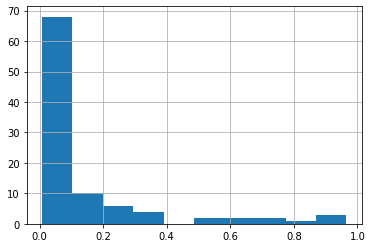

In [ ]:
entropy = pd.Series(-(np.log(preds) * preds).sum(1))
entropy.hist();

In [ ]:
pd.Series(preds.argmax(1)==facts).groupby(pd.qcut(entropy, 5)).aggregate([len, np.mean])

,len,mean
"(0.006979999999999999, 0.0127]",20,0.950000
"(0.0127, 0.0169]",19,0.947368
"(0.0169, 0.0353]",20,0.900000
"(0.0353, 0.21]",19,0.684211
"(0.21, 0.965]",20,0.400000


In [ ]:
!zip -r bert-effect-classifier-20210731.zip bert-effect-classifier-20210731

  adding: bert-effect-classifier-20210731/ (stored 0%)
  adding: bert-effect-classifier-20210731/vocab.txt (deflated 49%)
  adding: bert-effect-classifier-20210731/special_tokens_map.json (deflated 40%)
  adding: bert-effect-classifier-20210731/pytorch_model.bin (deflated 7%)
  adding: bert-effect-classifier-20210731/config.json (deflated 51%)
  adding: bert-effect-classifier-20210731/tokenizer_config.json (deflated 42%)
  adding: bert-effect-classifier-20210731/tokenizer.json (deflated 57%)


# Сбор выборки на разметку

Задача - разметить 1000 новых наблюдений, с соблюдением следующих критериев:

1. Должно быть размечено довольно много статей с каждым из 4 эффектов (хотя бы по 150 с каждым эффектом)
2. В выборку должны попасть в основном статьи, для которых текущая модель не очень уверена. 

In [ ]:
unlabeled = pd.read_csv('export-2.csv')
print(unlabeled.shape)
already = set(data.PMID)
unlabeled = unlabeled[unlabeled.PMID.apply(lambda x: x not in already)]
print(unlabeled.shape)
unlabeled.dropna(subset=['Abstract'], inplace=True)
print(unlabeled.shape)

(6773, 26)
(6159, 26)
(6044, 26)


In [ ]:
drugs_full_confident_list ={'delta-9-cis-tetrahydrocannabinol', 'cannabichromanon', 'cbc-v', 'cbf', 'cbem', 'cbla', 'delta-9-tetrahydrocannabinolic acid-c4', 'cannabidiolic acid', 'delta-9-tetrahydrocannabinolic acid a', 'cannabitriol', 'thcv', '8,9-dihydroxy-delta-6a-tetrahydrocannabinol', 'cannabivarin', 'cbnm-c5', 'cannabidivarinic acid', 'cbdv', 'cbe', 'cbr', 'cannabinol-c2', 'cbga', 'cannabichromevarinic acid', 'cannabidivarin', 'cbcf', 'cannabielsoin monomethylether', 'cbda', 'cannabicyclol', 'cbna', 'cbca', 'cbd-c4', 'cannabiorcool', 'delta-9-tetrahydrocannabinol-c4', 'cbgam', 'othc', 'oh-iso-hhcv', 'cannabigerolic acid', 'cbn-c1', 'cannabicyclolic acid', 'dcbf', 'cannabielsoic acid b', 'cannabielsoin', 'cbdm', 'delta-9-tetrahydrocannabinolic acid b', 'cannabicyclovarin', 'δ8-thc', 'delta-9-tetrahydrocannabiorcolic acid', 'cbv', 'cbgva', 'cbd-c1', 'cannabinol methylether', 'cbea-b', 'cbn-c3', 'cbg', 'cbtv', 'cannabigerolic acid monomethylether', 'cannabinolic acid-c5 a', 'thc-a', 'cbnv', 'cannabinol methylether-c5', 'delta-8-tetrahydrocannabinolic acid', 'cannabichromenic acid', 'thca-b', 'delta-9-tetrahydrocannabivarinic acid', 'cbgv', 'thc', 'delta-9-tetrahydrocannabiorcol', 'cblv', 'cannabidiol-c4', 'tetrahydrocannabinol', 'cbnd-c3', 'cis-thc', 'cbd-v', 'δ8-thca', 'cannabidiol', 'cbd-c5', 'tetrahydrocannabivarin', 'trioh-thc', '10-oxo-delta-6a-tetrahydrocannabinol', 'cbea-a', 'cannabichromevarin', 'cbdva', 'cannabinolic acid', 'cannabigerovarin', 'cannabinodiol-c3', 'thca', 'cbn', 'cbcv', 'cannabigerol monomethylether', 'cbl', 'thc-c1', 'cbvd', 'cannabichromene', 'cbna-c5 a', 'd9-thcv', 'cbnd', 'delta-9-tetrahydrocannabivarin', 'tetrahydrocannabinolic acid', 'cbt', 'cbc', 'delta-8-tetrahydrocannabinol', 'cbg-v', 'dehydrocannabifuran', 'cbd', 'thc-v', 'cannabiglendol', 'cannabinol-c3', 'cannabinol-c4', 'cbnm', 'cannabigerol', 'cannabitriolvarin', 'tryhydroxy-delta-9-tetrahydrocannabinol', 'd9-thcva', 'cannabidiol monomethyl', 'thca-a', 'cbcva', 'cbgm', 'cannabielsoin acid a', 'cannabinodivarin', 'thcva', 'cannabinovarin', 'thc-c4', 'cannabinodiol i', 'cannabidiol-c5', 'cannabinol', 'cannabigerovarinic acid', '10-ethoxy-9-hydroxy-delta-6a-tetrahydrocannabinol', 'thca-c1', 'cannabifuran', 'cannabiripsol', 'cbn-c2', 'cannabidiorcol', 'thca-c4', 'cbn-c4'}


In [ ]:
unlabeled['text_lhs'] = unlabeled.apply(lambda row: f'Compound: {row.Compound}; Indication: {row.Indication}', axis=1)
unlabeled['text_rhs'] = unlabeled.apply(lambda row: f'Title: {row["Article Name"]}\n{get_abstact_text(row.Abstract)}', axis=1)

In [ ]:
filter1 = unlabeled.text_rhs.str.lower().str.contains('canna')
filter2 = unlabeled.text_rhs.apply(lambda x: any(drug in x.lower() for drug in drugs_full_confident_list))

print(filter1.sum(), filter2.sum(), (filter1 & filter2).sum())

6043 5088 5088


In [ ]:
unlabeled_filtered = unlabeled[filter1 & filter2].copy()

In [ ]:
un_dataset = Dataset.from_dict({
    'text1': unlabeled_filtered.text_lhs,
    'text2': unlabeled_filtered.text_rhs,
    'label': unlabeled_filtered.Effect.apply(lambda x: all_labels.index(x))
}).map(tokenize, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
un_dataloader = DataLoader(
    un_dataset.remove_columns(['text1', 'text2']), 
    batch_size=batch_size, 
    drop_last=False, 
    shuffle=True, 
    num_workers=1, 
    collate_fn=data_collator
)

In [ ]:
new_labels, new_pred = batched_predict(model, un_dataloader)

  0%|          | 0/318 [00:00<?, ?it/s]

In [ ]:
pd.Series(new_pred.argmax(1)).value_counts()

3    3465
2    1519
0     104
dtype: int64

In [ ]:

class_count = data_train.Effect.apply(lambda x: all_labels.index(x)).value_counts().sort_index().values
print(class_count)

[ 37   8  53 293]


In [ ]:
pd.Series((new_pred / class_count).argmax(1)).value_counts()

3    2915
2    1986
0     184
1       3
dtype: int64

In [ ]:
pd.Series((new_pred / class_count ** 2).argmax(1)).value_counts()

3    2357
2    2297
0     275
1     159
dtype: int64

In [ ]:
all_labels

['NONE', 'SAFE', 'negative', 'positive']

In [ ]:
(new_pred > 0.2).sum(0)

array([ 219,    1, 1963, 3952])

In [ ]:
soft_pred = (new_pred / class_count).argmax(1)
soft_pred2 = (new_pred / class_count).argmax(1)

In [ ]:
len(set(
    np.where(new_pred[:, 0] > 0.5)[0]
))

92

Эвристика: чем больше модель неуверена в своих предсказаниях, тем чаще она ошибается

In [ ]:
entropy = -(np.log(new_pred) * new_pred).sum(1)

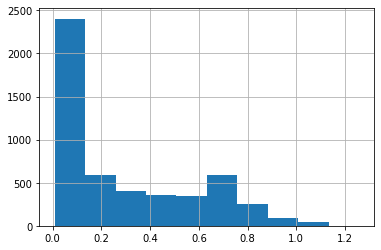

In [ ]:
pd.Series(entropy).hist()

In [ ]:
print(sum(entropy>1))
print(sum(entropy>0.8))

56
265


In [ ]:
sampled_indices = set(
    pd.Series(soft_pred2).groupby(soft_pred2).apply(lambda x: x.index.to_series().sample(300, replace=True, random_state=1)).values
).union(set(
    np.where(new_pred[:, 1] > 0.01)[0]
)).union(set(
    np.where(new_pred[:, 0] > 0.4)[0]
)).union(set(
    np.where(entropy >= 0.75)[0]
))
print(len(sampled_indices))

1049


In [ ]:
max(sampled_indices), unlabeled_filtered.shape

(5087, (5088, 28))

In [ ]:
unlabeled_filtered.iloc[sorted(sampled_indices)].to_csv('least_confident_samples_20210731.csv')